In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[3]').appName('churnAnalysis').getOrCreate()

In [3]:
# File location and type
file_location = "./data.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .option('nanValue', ' ')\
  .option('nullValue', ' ')\
  .load(file_location)

display(df)

DataFrame[customerID: string, gender: string, SeniorCitizen: int, Partner: string, Dependents: string, tenure: int, PhoneService: string, MultipleLines: string, InternetService: string, OnlineSecurity: string, OnlineBackup: string, DeviceProtection: string, TechSupport: string, StreamingTV: string, StreamingMovies: string, Contract: string, PaperlessBilling: string, PaymentMethod: string, MonthlyCharges: double, TotalCharges: double, Churn: string]

In [4]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



In [6]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).collect()

[Row(customerID=0, gender=0, SeniorCitizen=0, Partner=0, Dependents=0, tenure=0, PhoneService=0, MultipleLines=0, InternetService=0, OnlineSecurity=0, OnlineBackup=0, DeviceProtection=0, TechSupport=0, StreamingTV=0, StreamingMovies=0, Contract=0, PaperlessBilling=0, PaymentMethod=0, MonthlyCharges=0, TotalCharges=11, Churn=0)]

In [7]:
# Create a view or table

temp_table_name = "churn_analysis"

df.createOrReplaceTempView(temp_table_name)

In [8]:
pd_df=df.toPandas()

C:\Users\gradv\.conda\envs\spark\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


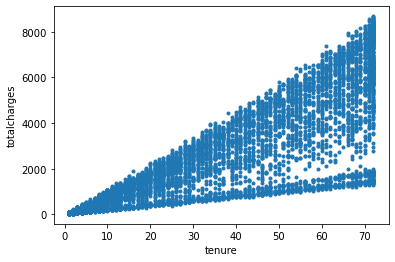

In [9]:
import matplotlib.pyplot as plt
plt.clf()
plt.plot(pd_df['tenure'], pd_df['TotalCharges'], '.')
plt.xlabel('tenure')
plt.ylabel('totalcharges')
display()

In [12]:
df.groupBy('Churn').count().collect()

[Row(Churn='No', count=5174), Row(Churn='Yes', count=1869)]

In [15]:
df.select('tenure','TotalCharges','MonthlyCharges').describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
tenure,7043,32.37114865824223,24.559481023094442,0,72
TotalCharges,7032,2283.3004408418697,2266.771361883145,18.8,8684.8
MonthlyCharges,7043,64.76169246059922,30.090047097678482,18.25,118.75


In [16]:
df.stat.crosstab("SeniorCitizen", "InternetService").collect()

[Row(SeniorCitizen_InternetService='1', DSL=259, Fiber optic=831, No=52),
 Row(SeniorCitizen_InternetService='0', DSL=2162, Fiber optic=2265, No=1474)]

In [17]:
df.stat.freqItems(["PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"], 0.6).collect()

[Row(PhoneService_freqItems=['Yes'], MultipleLines_freqItems=['Yes'], InternetService_freqItems=['Fiber optic'], OnlineSecurity_freqItems=['No'], OnlineBackup_freqItems=['Yes'], DeviceProtection_freqItems=['No'], TechSupport_freqItems=['No'], StreamingTV_freqItems=['Yes'], StreamingMovies_freqItems=['No'])]

In [18]:
churn_df = df
(train_data, test_data) = churn_df.randomSplit([0.7, 0.3], 24)

print("Records for training: " + str(train_data.count()))
print("Records for evaluation: " + str(test_data.count()))

Records for training: 4916
Records for evaluation: 2127


In [19]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

catColumns = ["gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies","Contract","PaperlessBilling","PaymentMethod"]

C:\Users\gradv\.conda\envs\spark\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [20]:
stages= []

for catCol in catColumns:
    stringIndexer = StringIndexer(inputCol=catCol, outputCol=catCol + "Index")
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[catCol + "catVec"])
    stages += [stringIndexer, encoder]

In [21]:
stages

[StringIndexer_1c95dd1ed841,
 OneHotEncoderEstimator_34ebdc31eb1e,
 StringIndexer_9907c4855ec2,
 OneHotEncoderEstimator_431c1b6b9d24,
 StringIndexer_e346d1a05034,
 OneHotEncoderEstimator_f2ebe414e0ce,
 StringIndexer_d7d43035559b,
 OneHotEncoderEstimator_92651c6c69e8,
 StringIndexer_ffc73ea005c7,
 OneHotEncoderEstimator_2c12cc58aa14,
 StringIndexer_21cd17bd5bce,
 OneHotEncoderEstimator_4e15b4dd32c8,
 StringIndexer_4424bdbecfb3,
 OneHotEncoderEstimator_cf1087ce7543,
 StringIndexer_feeb707131de,
 OneHotEncoderEstimator_3e09afc7516c,
 StringIndexer_feda03e873e0,
 OneHotEncoderEstimator_f76014c19b67,
 StringIndexer_ecf0be8b1a41,
 OneHotEncoderEstimator_4f836f0195a9,
 StringIndexer_69a6d909513f,
 OneHotEncoderEstimator_e727c0f495d3,
 StringIndexer_96e42ece4198,
 OneHotEncoderEstimator_2bf1ad0546cb,
 StringIndexer_a44f780ebf04,
 OneHotEncoderEstimator_89f85d0facd5,
 StringIndexer_2f299262304b,
 OneHotEncoderEstimator_59f2e0b84456,
 StringIndexer_0f883ca632cd,
 OneHotEncoderEstimator_2322036d4

In [22]:
from pyspark.ml.feature import Imputer
imputer = Imputer(inputCols=["TotalCharges"], outputCols=["Out_TotalCharges"])
stages += [imputer]

In [23]:
label_Idx = StringIndexer(inputCol="Churn", outputCol="label")
stages += [label_Idx]

In [24]:
temp=label_Idx.fit(train_data).transform(train_data)

In [26]:
temp.take(1)

[Row(customerID='0004-TLHLJ', gender='Male', SeniorCitizen=0, Partner='No', Dependents='No', tenure=4, PhoneService='Yes', MultipleLines='No', InternetService='Fiber optic', OnlineSecurity='No', OnlineBackup='No', DeviceProtection='Yes', TechSupport='No', StreamingTV='No', StreamingMovies='No', Contract='Month-to-month', PaperlessBilling='Yes', PaymentMethod='Electronic check', MonthlyCharges=73.9, TotalCharges=280.85, Churn='Yes', label=1.0)]

In [27]:
df.stat.corr('TotalCharges', 'MonthlyCharges')

0.6511738315787813

In [28]:
from pyspark.ml.feature import QuantileDiscretizer
tenure_bin = QuantileDiscretizer(numBuckets=3, inputCol="tenure", outputCol="tenure_bin")
stages += [tenure_bin]

In [29]:
stages

[StringIndexer_1c95dd1ed841,
 OneHotEncoderEstimator_34ebdc31eb1e,
 StringIndexer_9907c4855ec2,
 OneHotEncoderEstimator_431c1b6b9d24,
 StringIndexer_e346d1a05034,
 OneHotEncoderEstimator_f2ebe414e0ce,
 StringIndexer_d7d43035559b,
 OneHotEncoderEstimator_92651c6c69e8,
 StringIndexer_ffc73ea005c7,
 OneHotEncoderEstimator_2c12cc58aa14,
 StringIndexer_21cd17bd5bce,
 OneHotEncoderEstimator_4e15b4dd32c8,
 StringIndexer_4424bdbecfb3,
 OneHotEncoderEstimator_cf1087ce7543,
 StringIndexer_feeb707131de,
 OneHotEncoderEstimator_3e09afc7516c,
 StringIndexer_feda03e873e0,
 OneHotEncoderEstimator_f76014c19b67,
 StringIndexer_ecf0be8b1a41,
 OneHotEncoderEstimator_4f836f0195a9,
 StringIndexer_69a6d909513f,
 OneHotEncoderEstimator_e727c0f495d3,
 StringIndexer_96e42ece4198,
 OneHotEncoderEstimator_2bf1ad0546cb,
 StringIndexer_a44f780ebf04,
 OneHotEncoderEstimator_89f85d0facd5,
 StringIndexer_2f299262304b,
 OneHotEncoderEstimator_59f2e0b84456,
 StringIndexer_0f883ca632cd,
 OneHotEncoderEstimator_2322036d4

In [30]:
numericCols = ["tenure_bin", "Out_TotalCharges","MonthlyCharges"]
assembleInputs = assemblerInputs = [c + "catVec" for c in catColumns] + numericCols
assembler = VectorAssembler(inputCols=assembleInputs, outputCol="features")
stages += [assembler]

In [31]:
pipeline = Pipeline().setStages(stages)
pipelineModel = pipeline.fit(train_data)

In [32]:
trainprepDF = pipelineModel.transform(train_data)
testprepDF = pipelineModel.transform(test_data)

In [33]:
trainprepDF.head(1)

[Row(customerID='0004-TLHLJ', gender='Male', SeniorCitizen=0, Partner='No', Dependents='No', tenure=4, PhoneService='Yes', MultipleLines='No', InternetService='Fiber optic', OnlineSecurity='No', OnlineBackup='No', DeviceProtection='Yes', TechSupport='No', StreamingTV='No', StreamingMovies='No', Contract='Month-to-month', PaperlessBilling='Yes', PaymentMethod='Electronic check', MonthlyCharges=73.9, TotalCharges=280.85, Churn='Yes', genderIndex=1.0, gendercatVec=SparseVector(1, {}), SeniorCitizenIndex=0.0, SeniorCitizencatVec=SparseVector(1, {0: 1.0}), PartnerIndex=0.0, PartnercatVec=SparseVector(1, {0: 1.0}), DependentsIndex=0.0, DependentscatVec=SparseVector(1, {0: 1.0}), PhoneServiceIndex=0.0, PhoneServicecatVec=SparseVector(1, {0: 1.0}), MultipleLinesIndex=0.0, MultipleLinescatVec=SparseVector(2, {0: 1.0}), InternetServiceIndex=0.0, InternetServicecatVec=SparseVector(2, {0: 1.0}), OnlineSecurityIndex=0.0, OnlineSecuritycatVec=SparseVector(2, {0: 1.0}), OnlineBackupIndex=0.0, OnlineB

In [35]:
trainprepDF.select("tenure_bin").take(5)

[Row(tenure_bin=0.0),
 Row(tenure_bin=0.0),
 Row(tenure_bin=2.0),
 Row(tenure_bin=0.0),
 Row(tenure_bin=2.0)]

In [36]:
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# Train model with Training Data
lrModel = lr.fit(trainprepDF)

In [37]:
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: [-0.022125908958674067,-0.295966602853141,-0.04540190713043998,0.11422451989175594,-0.5443650552564775,-0.25787179594555176,0.06759355518729251,0.558940086914602,-0.3986256243196881,0.3000315276725239,-0.13495490629289175,0.1906494657387726,0.0034263879839864985,0.1139377637255167,0.0864700306602351,0.26398039586831734,-0.08866299958063091,0.005764718914013356,0.1946886963208213,-0.012545144725579329,0.21249251749087097,0.7226916232199266,-0.7941298473778351,0.30458357823925264,0.18868980558464654,-0.11391177062150766,-0.27808713414588604,-0.6330144913097795,-0.00011781853833584495,0.004850253631019678]
Intercept: -1.1241531294140892


In [38]:
summary=lrModel.summary

In [39]:
accuracy = summary.accuracy
falsePositiveRate = summary.weightedFalsePositiveRate
truePositiveRate = summary.weightedTruePositiveRate
fMeasure = summary.weightedFMeasure()
precision = summary.weightedPrecision
recall = summary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s\nAreaUnderROC: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall, summary.areaUnderROC))

Accuracy: 0.7971928397070789
FPR: 0.3543249783512605
TPR: 0.7971928397070789
F-measure: 0.7916719573031158
Precision: 0.7893734580163737
Recall: 0.7971928397070789
AreaUnderROC: 0.8462856449884067


In [40]:
display(lrModel, trainprepDF, "ROC")

LogisticRegressionModel: uid = LogisticRegression_94994250d66b, numClasses = 2, numFeatures = 30

DataFrame[customerID: string, gender: string, SeniorCitizen: int, Partner: string, Dependents: string, tenure: int, PhoneService: string, MultipleLines: string, InternetService: string, OnlineSecurity: string, OnlineBackup: string, DeviceProtection: string, TechSupport: string, StreamingTV: string, StreamingMovies: string, Contract: string, PaperlessBilling: string, PaymentMethod: string, MonthlyCharges: double, TotalCharges: double, Churn: string, genderIndex: double, gendercatVec: vector, SeniorCitizenIndex: double, SeniorCitizencatVec: vector, PartnerIndex: double, PartnercatVec: vector, DependentsIndex: double, DependentscatVec: vector, PhoneServiceIndex: double, PhoneServicecatVec: vector, MultipleLinesIndex: double, MultipleLinescatVec: vector, InternetServiceIndex: double, InternetServicecatVec: vector, OnlineSecurityIndex: double, OnlineSecuritycatVec: vector, OnlineBackupIndex: double, OnlineBackupcatVec: vector, DeviceProtectionIndex: double, DeviceProtectioncatVec: vector, T

'ROC'

In [41]:
display(lrModel, trainprepDF, "fittedVsResiduals")

LogisticRegressionModel: uid = LogisticRegression_94994250d66b, numClasses = 2, numFeatures = 30

DataFrame[customerID: string, gender: string, SeniorCitizen: int, Partner: string, Dependents: string, tenure: int, PhoneService: string, MultipleLines: string, InternetService: string, OnlineSecurity: string, OnlineBackup: string, DeviceProtection: string, TechSupport: string, StreamingTV: string, StreamingMovies: string, Contract: string, PaperlessBilling: string, PaymentMethod: string, MonthlyCharges: double, TotalCharges: double, Churn: string, genderIndex: double, gendercatVec: vector, SeniorCitizenIndex: double, SeniorCitizencatVec: vector, PartnerIndex: double, PartnercatVec: vector, DependentsIndex: double, DependentscatVec: vector, PhoneServiceIndex: double, PhoneServicecatVec: vector, MultipleLinesIndex: double, MultipleLinescatVec: vector, InternetServiceIndex: double, InternetServicecatVec: vector, OnlineSecurityIndex: double, OnlineSecuritycatVec: vector, OnlineBackupIndex: double, OnlineBackupcatVec: vector, DeviceProtectionIndex: double, DeviceProtectioncatVec: vector, T

'fittedVsResiduals'

In [42]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
predictions = lrModel.transform(testprepDF)
evaluatorLR = BinaryClassificationEvaluator(rawPredictionCol="prediction")
area_under_curve = evaluatorLR.evaluate(predictions)

#default evaluation is areaUnderROC
print("areaUnderROC = %g" % area_under_curve)

evaluatorLR.getMetricName()


areaUnderROC = 0.723089


'areaUnderROC'

In [44]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

results = predictions.select(['prediction', 'label'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0]), float(i[1])) for i in results_collect]
predictionAndLabels = spark.sparkContext.parallelize(results_list)
 
metrics = BinaryClassificationMetrics(predictionAndLabels)

# Area under precision-recall curve
print("Area under PR = %s" % metrics.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)

predictions.take(1)

Area under PR = 0.5264394725677182
Area under ROC = 0.7230887671429083


[Row(customerID='0002-ORFBO', gender='Female', SeniorCitizen=0, Partner='Yes', Dependents='Yes', tenure=9, PhoneService='Yes', MultipleLines='No', InternetService='DSL', OnlineSecurity='No', OnlineBackup='Yes', DeviceProtection='No', TechSupport='Yes', StreamingTV='Yes', StreamingMovies='No', Contract='One year', PaperlessBilling='Yes', PaymentMethod='Mailed check', MonthlyCharges=65.6, TotalCharges=593.3, Churn='No', genderIndex=0.0, gendercatVec=SparseVector(1, {0: 1.0}), SeniorCitizenIndex=0.0, SeniorCitizencatVec=SparseVector(1, {0: 1.0}), PartnerIndex=1.0, PartnercatVec=SparseVector(1, {}), DependentsIndex=1.0, DependentscatVec=SparseVector(1, {}), PhoneServiceIndex=0.0, PhoneServicecatVec=SparseVector(1, {0: 1.0}), MultipleLinesIndex=0.0, MultipleLinescatVec=SparseVector(2, {0: 1.0}), InternetServiceIndex=1.0, InternetServicecatVec=SparseVector(2, {1: 1.0}), OnlineSecurityIndex=0.0, OnlineSecuritycatVec=SparseVector(2, {0: 1.0}), OnlineBackupIndex=1.0, OnlineBackupcatVec=SparseVe

In [45]:
test_data.groupBy('Churn').count().collect()

[Row(Churn='No', count=1605), Row(Churn='Yes', count=522)]

In [46]:
count=predictions.count()
correct = results.filter(results.prediction == results.label).count()
wrong = results.filter(results.prediction != results.label).count()
tp = results.filter(results.prediction == 1.0).filter(results.prediction == results.label).count()
fp = results.filter(results.prediction == 1.0).filter(results.prediction != results.label).count()
fn = results.filter(results.prediction == 0.0).filter(results.prediction != results.label).count()
tn = results.filter(results.prediction == 0.0).filter(results.prediction == results.label).count()

accuracy = (tp+tn)/count

precision = tp/(tp+fp)

recall = tp/(tp+fn)

print("Correct: %s\nWrong: %s\ntp: %s\nfp: %s\nfn: %s\ntn: %s\nAccuracy: %s\nPrecision: %s\nRecall: %s"
      % (correct, wrong, tp, fp, fn, tn, accuracy, precision, recall))


Correct: 1707
Wrong: 420
tp: 296
fp: 194
fn: 226
tn: 1411
Accuracy: 0.8025387870239774
Precision: 0.6040816326530613
Recall: 0.5670498084291188


In [47]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [5, 10, 20])
             .build())

In [48]:
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluatorLR, numFolds=5)

# Run cross validations
cvModel = cv.fit(trainprepDF)

In [49]:
predictions = cvModel.bestModel.transform(testprepDF)

In [50]:
evaluatorLR.evaluate(predictions)

0.7268270848999175

In [51]:
results = predictions.select(['prediction', 'label'])

count=predictions.count()
correct = results.filter(results.prediction == results.label).count()
wrong = results.filter(results.prediction != results.label).count()
tp = results.filter(results.prediction == 1.0).filter(results.prediction == results.label).count()
fp = results.filter(results.prediction == 1.0).filter(results.prediction != results.label).count()
fn = results.filter(results.prediction == 0.0).filter(results.prediction != results.label).count()
tn = results.filter(results.prediction == 0.0).filter(results.prediction == results.label).count()

accuracy = (tp+tn)/count

precision = tp/(tp+fp)

recall = tp/(tp+fn)

print("Correct: %s\nWrong: %s\ntp: %s\nfp: %s\nfn: %s\ntn: %s\nAccuracy: %s\nPrecision: %s\nRecall: %s"
      % (correct, wrong, tp, fp, fn, tn, accuracy, precision, recall))


Correct: 1719
Wrong: 408
tp: 296
fp: 182
fn: 226
tn: 1423
Accuracy: 0.8081805359661495
Precision: 0.6192468619246861
Recall: 0.5670498084291188


In [52]:
cvModel.explainParams()

"estimator: estimator to be cross-validated (current: LogisticRegression_94994250d66b)\nestimatorParamMaps: estimator param maps (current: [{Param(parent='LogisticRegression_94994250d66b', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='LogisticRegression_94994250d66b', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_94994250d66b', name='maxIter', doc='max number of iterations (>= 0).'): 5}, {Param(parent='LogisticRegression_94994250d66b', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='LogisticRegression_94994250d66b', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_94994250d66b', name='maxIter', doc='max number of iterations

In [53]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features").setImpurity("gini").setMaxDepth(6).setNumTrees(50).setFeatureSubsetStrategy("auto").setSeed(1010)

rfModel = rf.fit(trainprepDF)

In [54]:
predictions = rfModel.transform(testprepDF)

In [55]:
results = predictions.select(['prediction', 'label'])

count=predictions.count()
correct = results.filter(results.prediction == results.label).count()
wrong = results.filter(results.prediction != results.label).count()
tp = results.filter(results.prediction == 1.0).filter(results.prediction == results.label).count()
fp = results.filter(results.prediction == 1.0).filter(results.prediction != results.label).count()
fn = results.filter(results.prediction == 0.0).filter(results.prediction != results.label).count()
tn = results.filter(results.prediction == 0.0).filter(results.prediction == results.label).count()

accuracy = (tp+tn)/count

precision = tp/(tp+fp)

recall = tp/(tp+fn)

print("Correct: %s\nWrong: %s\ntp: %s\nfp: %s\nfn: %s\ntn: %s\nAccuracy: %s\nPrecision: %s\nRecall: %s"
      % (correct, wrong, tp, fp, fn, tn, accuracy, precision, recall))


Correct: 1728
Wrong: 399
tp: 264
fp: 141
fn: 258
tn: 1464
Accuracy: 0.8124118476727785
Precision: 0.6518518518518519
Recall: 0.5057471264367817
